
Load input features..

Load distance maps features..

Some cross checks on data loading..

Find the number of input channels..

Split into training and validation set (5%)..
('Total validation proteins = ', 10)
('Total training proteins = ', 200)

Prepare the validation input and outputs..
(10, 256, 256, 13)
(10, 256, 256, 1)

Prepare the training input and outputs..
(200, 256, 256, 13)
(200, 256, 256, 1)

Sanity check input features values..
 First validation protein:
 Channel        Avg        Max        Sum
       0     0.4457     0.9970    29210.6
       1     0.4457     0.9970    29210.6
       2     0.3147     0.9930    20622.6
       3     0.3147     0.9930    20622.6
       4     0.2157     0.9920    14137.9
       5     0.2157     0.9920    14137.9
       6     0.2594     0.8880    17002.8
       7     0.2594     0.8880    17002.8
       8     0.6736     0.9460    44145.7
       9     0.6736     0.9460    44145.7
      10     0.1118     1.0000     7324.6
      11     0.1328  

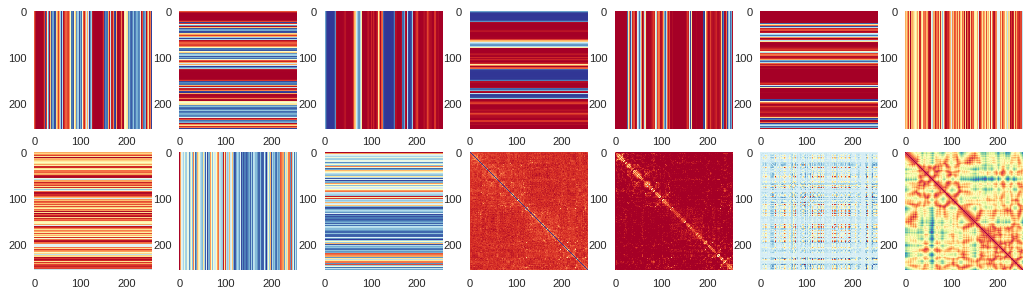

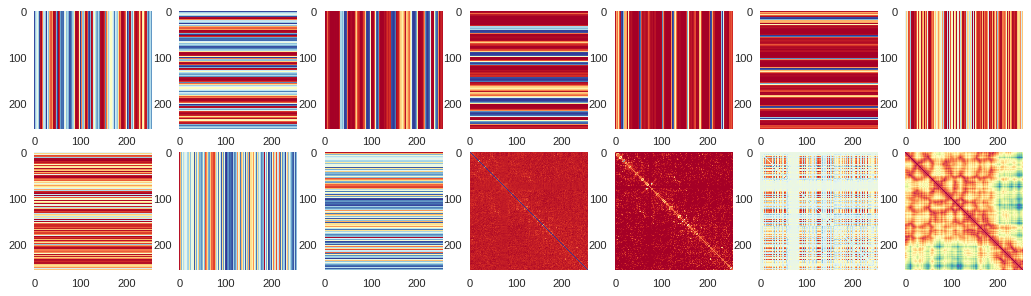

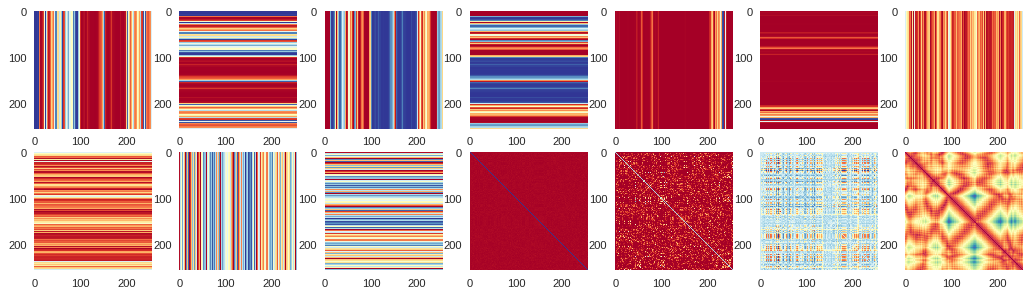

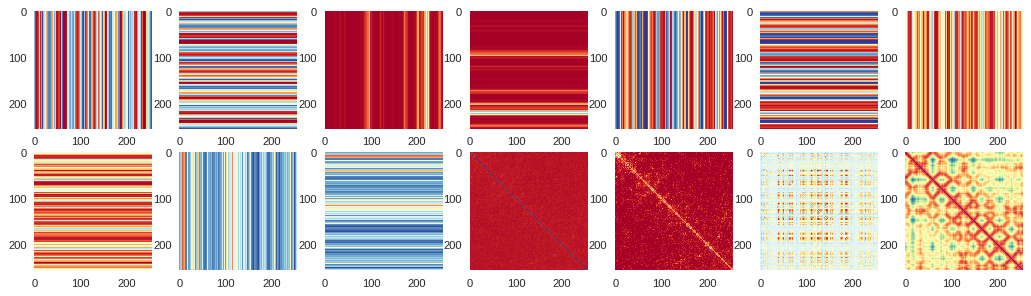

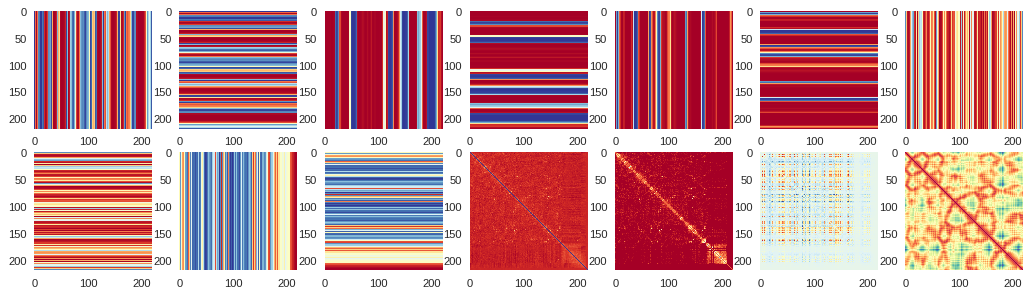


Build a model..
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 13)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256, 256, 13)      52        
_________________________________________________________________
activation_2 (Activation)    (None, 256, 256, 13)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      7552      
_________________________________________________________________
batch_normalization_3 (Batch (None, 256, 256, 64)      256       
_________________________________________________________________
activation_3 (Activation)    (None, 256, 256, 64)      0         
_____________________________________________________

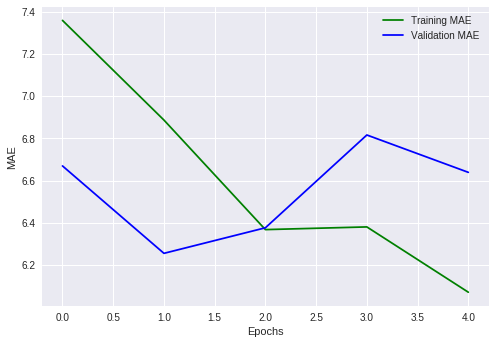


Make predictions..

Compare the predictions with the truths (for some proteins) ..






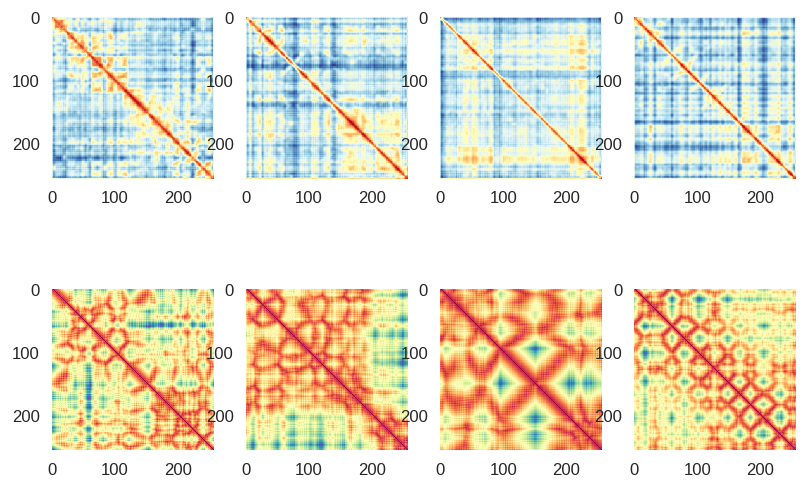


Evaluate MAE for top L long-range distance predictions on the validation set..
('MAE for ', 0, ' is ', 4.66007868695115)


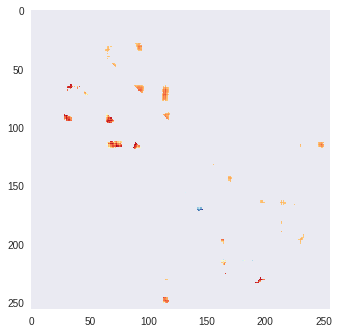

('MAE for ', 1, ' is ', 11.240133931167321)


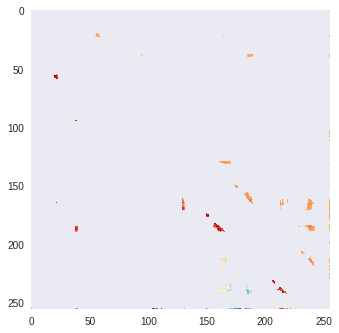

('MAE for ', 2, ' is ', 13.09808093901164)


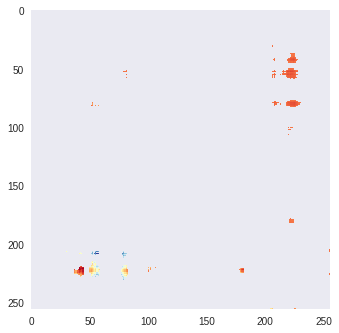

('MAE for ', 3, ' is ', 11.422684777894904)


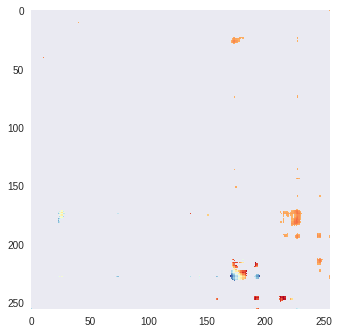

('MAE for ', 4, ' is ', 9.320962906664388)


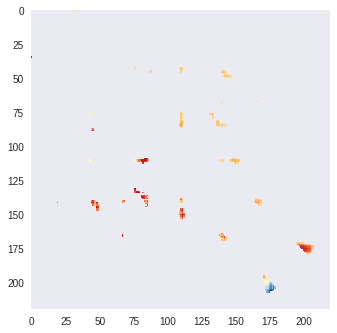

('MAE for ', 5, ' is ', 7.1318221643112985)


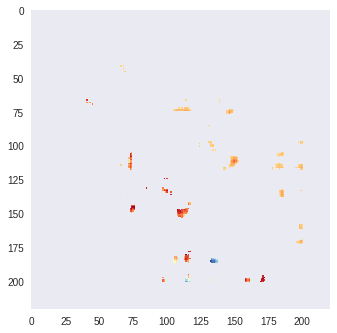

('MAE for ', 6, ' is ', 5.471315728893923)


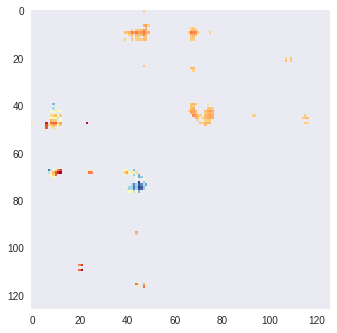

('MAE for ', 7, ' is ', 7.248125055863001)


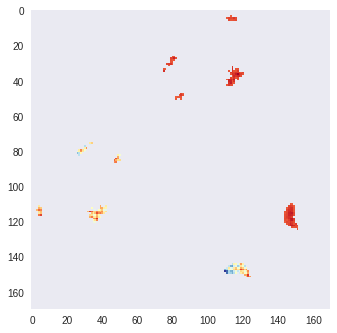

('MAE for ', 8, ' is ', 2.831611896580061)


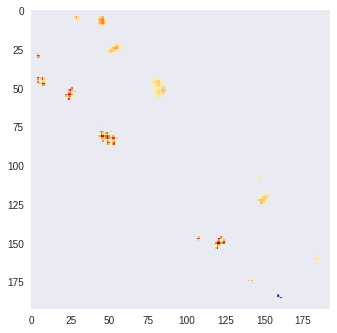

('MAE for ', 9, ' is ', 13.516099557357588)


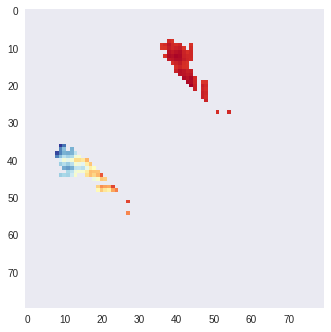

('Average MAE (on validation set) = ', 8.594091564469528)


In [2]:
# 3-26-2019
# Badri Adhikari
# https://badriadhikari.github.io/

import numpy as np
from keras.models import *
from keras.layers import *
from keras.callbacks import *

import keras.backend as K
epsilon = K.epsilon()

from io import BytesIO, StringIO
from tensorflow.python.lib.io import file_io

flag_visuals = True

print('')
print('Load input features..')
# .npy was encoded using Python 2
x = BytesIO(file_io.read_file_to_string('gs://protein-distance/sample-input-features.npy'))
(pdb_list, length_dict, input_features)  = np.load(x)

print('')
print('Load distance maps features..')
# .npy was encoded using Python 2
x = BytesIO(file_io.read_file_to_string('gs://protein-distance/sample-distance-maps-cb.npy'))
(pdb_list_y, distance_maps_cb) = np.load(x)

print('')
print ('Some cross checks on data loading..')
for pdb in pdb_list:
    if not pdb in pdb_list_y:
        print ('I/O mismatch ', pdb)
        sys.exit(1)

print('')
print('Find the number of input channels..')
F = 0
x = input_features[pdb_list[0]]
l = length_dict[pdb_list[0]]
for feature in x:
    if len(feature) == l:
        F += 2
    elif len(feature) == l * l:
        F += 1
    else:
        print('Expecting features to be either L or L*L !! Something went wrong!!', l, len(feature))
        sys.exit(1)

print('')
print('Split into training and validation set (5%)..')
split = int(0.05 * len(pdb_list))
valid_pdbs = pdb_list[:split]
train_pdbs = pdb_list[split:]

#for debugging
train_pdbs = pdb_list

print('Total validation proteins = ', len(valid_pdbs))
print('Total training proteins = ', len(train_pdbs))

# Roll out 1D features to two 2D features, all to 256 x 256 (because many are smaller)
def prepare_input_features_2D(pdbs):
    X = np.zeros((len(pdbs), 256, 256, F))
    Y = np.zeros((len(pdbs), 256, 256, 1))
    for i, pdb in enumerate(pdbs):
        x = input_features[pdb]
        y = distance_maps_cb[pdb]
        l = length_dict[pdb]
        newi = 0
        xmini = np.zeros((l, l, F))
        for feature in x:
            feature = np.array(feature)
            feature = feature.astype(np.float)        
            if len(feature) == l:
                for k in range(0, l):
                    xmini[k, :, newi] = feature
                    xmini[:, k, newi + 1] = feature
                newi += 2
            elif len(feature) == l * l:
                xmini[:, :, newi] = feature.reshape(l, l)
                newi += 1
            else:
                print('Expecting features to be either L or L*L !! Something went wrong!!', l, len(feature))
                sys.exit(1)
        X[i, 0:l, 0:l, :] = xmini
        Y[i, 0:l, 0:l, 0] = y
    return X, Y

print('')
print ('Prepare the validation input and outputs..')
XVALID, YVALID = prepare_input_features_2D(valid_pdbs)
print(XVALID.shape)
print(YVALID.shape)

print('')
print ('Prepare the training input and outputs..')
XTRAIN, YTRAIN = prepare_input_features_2D(train_pdbs)
print(XTRAIN.shape)
print(YTRAIN.shape)

def print_max_avg_sum_of_each_channel(x):
    print(' Channel        Avg        Max        Sum')
    for i in range(len(x[0, 0, :])):
        (m, s, a) = (x[:, :, i].flatten().max(), x[:, :, i].flatten().sum(), x[:, :, i].flatten().mean())
        print(' %7s %10.4f %10.4f %10.1f' % (i, a, m, s))

print('')
print('Sanity check input features values..')
print(' First validation protein:')
print_max_avg_sum_of_each_channel(XVALID[0, :, :, :])
print(' First traininig protein:')
print_max_avg_sum_of_each_channel(XTRAIN[0, :, :, :])

def plot_input_output_of_this_valid_protein(I):
    L = length_dict[pdb_list[I]]
    figure(num=None, figsize=(16, 16), dpi=80, facecolor='w', frameon=True, edgecolor='k')
    for i in range(13):
        plt.subplot(7, 7, i + 1)
        plt.grid(None)
        plt.imshow(XVALID[I, 0:L, 0:L, i], cmap='RdYlBu', interpolation='nearest')
    # Last plot is the true distance map
    plt.subplot(7, 7, 14)
    plt.grid(None)
    plt.imshow(YVALID[I, 0:L, 0:L, 0], cmap='Spectral', interpolation='nearest')
    plt.show()

if flag_visuals:
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    for i in range(5):
        print('')
        plot_input_output_of_this_valid_protein(i)

print('')
print('Build a model..')
depth = 8
input = Input(shape = (256, 256, F))
tower = BatchNormalization()(input)
tower = Activation('relu')(tower)
tower = Convolution2D(64, 3, padding = 'same')(tower)
tower = BatchNormalization()(input)
tower = Activation('relu')(tower)
tower = Convolution2D(64, 3, padding = 'same')(tower)
tower = BatchNormalization()(tower)
tower = Activation('relu')(tower)
tower = Convolution2D(1, 5, padding = 'same')(tower)
tower = Activation('linear')(tower)
model = Model(input, tower)

model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mae'])

print (model.summary())

# a simple early stopping
es = EarlyStopping(monitor = 'val_mean_absolute_error', mode = 'min', verbose = 1, patience = 50)
mc = ModelCheckpoint('model.h5', monitor = 'val_mean_absolute_error', mode = 'min', verbose = 1, save_best_only = True)

print('')
print('Train the model..')
history = model.fit(XTRAIN, YTRAIN, verbose = 1, batch_size = 2, epochs = 5, validation_data=(XVALID, YVALID), callbacks=[es, mc])

print('')
print('Cuves..')
if flag_visuals:
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    print(history.params)
    plt.clf()
    plt.plot(history.history['mean_absolute_error'], 'g', label='Training MAE')
    plt.plot(history.history['val_mean_absolute_error'], 'b', label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

print('')
print('Make predictions..')
P = model.predict(XVALID)

print('')
print('Compare the predictions with the truths (for some proteins) ..')
if flag_visuals:
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import figure
    figure(num=None, dpi=120, facecolor='w', frameon=True, edgecolor='k')
    I = 0
    for k in range(0, 4):
        L = length_dict[pdb_list[k]]
        plt.subplot(2, 4, k + 1)
        plt.grid(None)
        plt.imshow(P[k, 0:L, 0:L, 0], cmap='RdYlBu', interpolation='nearest')
        plt.subplot(2, 4, 4 + k + 1)
        plt.grid(None)
        plt.imshow(YVALID[k, 0:L, 0:L, 0], cmap='Spectral', interpolation='nearest')
        print('')
    plt.show()


print('')
print('Evaluate MAE for top L long-range distance predictions on the validation set..')
avg_mae = 0.0
for i in range(0, len(XVALID[:, 0, 0, 0])):
    L = length_dict[pdb_list[i]]
    p = np.copy(P[i, 0:L, 0:L, 0])
    y = np.copy(YVALID[i, 0:L, 0:L, 0])
    for j in range(0, L):
        for k in range(0, L):
            if k - j < 24:
                p[j, k] = np.inf
                y[j, k] = np.inf
    p_dict = {}
    y_dict = {}
    for j in range(0, L):
        for k in range(0, L):
            p_dict[(j,k)] = p[j, k]
            y_dict[(j,k)] = y[j, k]
    top_pairs = []
    x = L
    for pair in sorted(p_dict.items(), key=lambda x: x[1]):
        (k, v) = pair
        top_pairs.append(k)
        x -= 1
        if x == 0:
            break
    sum_mae = 0.0
    for pair in top_pairs:
        abs_dist = abs(y_dict[pair] - p_dict[pair])
        sum_mae += abs_dist
    sum_mae /= L
    avg_mae += sum_mae
    print('MAE for ', i, ' is ', sum_mae)
    if flag_visuals:
        # Visualization of prediction against truth
        # Legend: lower triangle = true, upper triangle = prediction
        for j in range(0, L):
            for k in range(0, L):
                if not (j, k) in top_pairs:
                    p[j, k] = np.inf
                    y[j, k] = np.inf               
        for j in range(0, L):
            for k in range(j, L):
                p[k, j] = y[j, k]
        plt.grid(None)
        plt.imshow(p, cmap='RdYlBu', interpolation='nearest')
        plt.show()

print('Average MAE (on validation set) = ', avg_mae / len(XVALID[:, 0, 0, 0]))